In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
from orbitize import results, plot
from orbitize.basis import tau_to_tp
from astropy import units as u, constants as cst
from astropy.time import Time
from scipy import stats

# TODO:
# 1. make plots for fit 3
# 2. run 6 other fits for full steps
# 3. compare parallax for 1A & 1B
# 4. where does the period alias come from?

# 1A
# planet = True
# run_name = "planetTrue_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_burn100_total25000000"

# 1B
# planet = False
# run_name = "planetFalse_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosTrue_burn100_total25000000"

# 3
planet = False
run_name = "planetFalse_dvdFalse_renormHIPFalse_fitradioTrue_fithipparcosFalse_burn100_total25000000"

beetle_results = results.Results()
beetle_results.load_results("results/{}.hdf5".format(run_name))

# create new dir for plots about this run
savedir = "plots/{}".format(run_name)
if not os.path.exists(savedir):
    os.mkdir(savedir)

Make corner plot, secondary mass plot, and period plot:

{'per1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'pm_ra': 7, 'pm_dec': 8, 'alpha0': 9, 'delta0': 10, 'm1': 11, 'm0': 12}


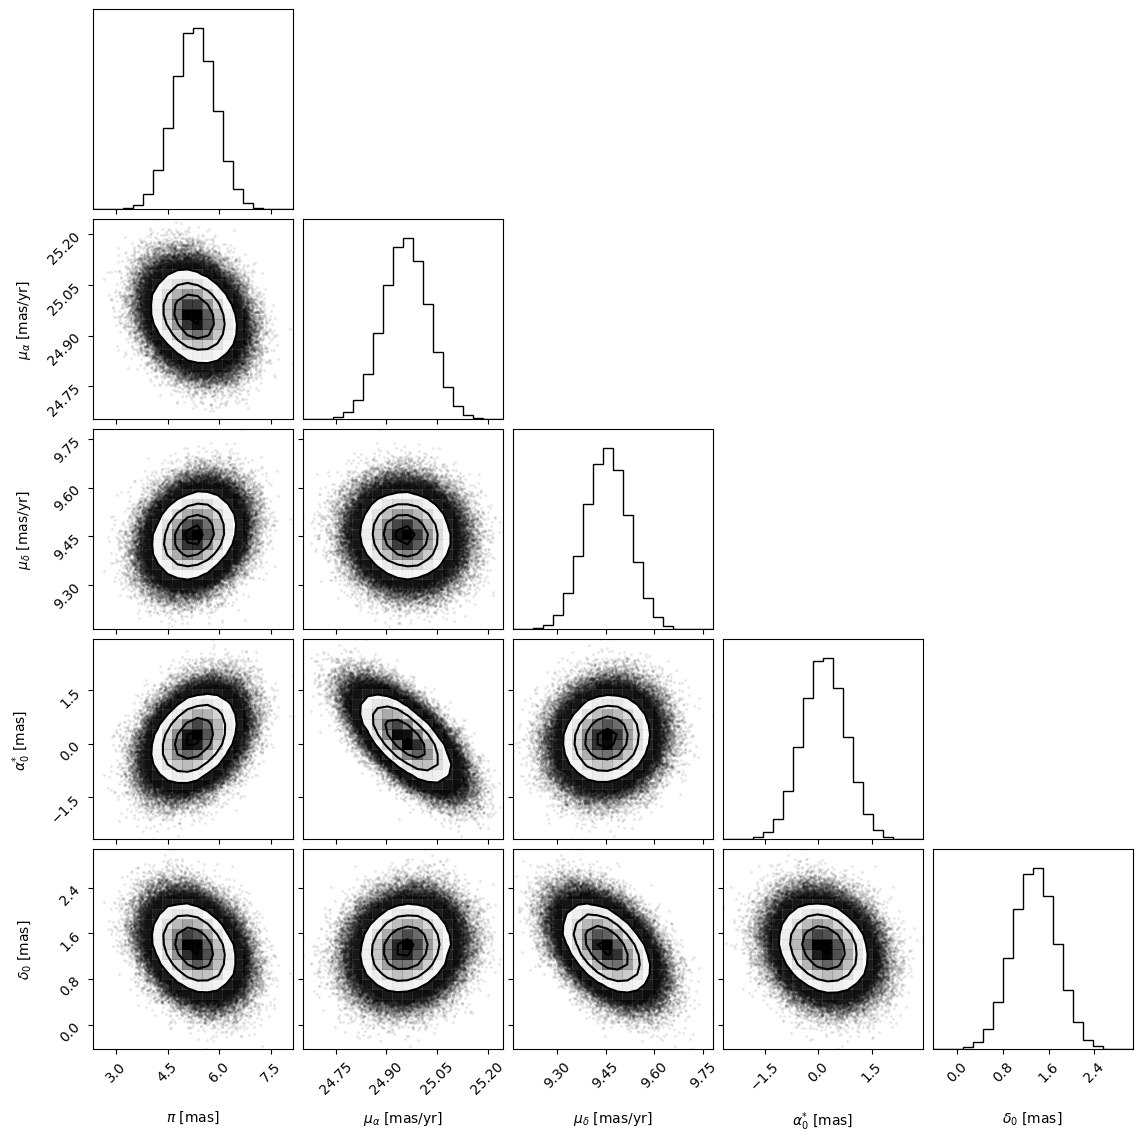

In [6]:
if not planet:
    param_list = ["plx", "pm_ra", "pm_dec", "alpha0", "delta0"]
else:
    param_list = [
        "plx",
        "pm_ra",
        "pm_dec",
        "alpha0",
        "delta0",
        "m0",
        "m1",
        "per1",
        "pan1",
        "tau1",
    ]

print(beetle_results.param_idx)
plot.plot_corner(beetle_results, param_list=param_list)
plt.savefig("{}/corner.png".format(savedir), dpi=250)

/home/sblunt/miniconda3/envs/python3.12/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


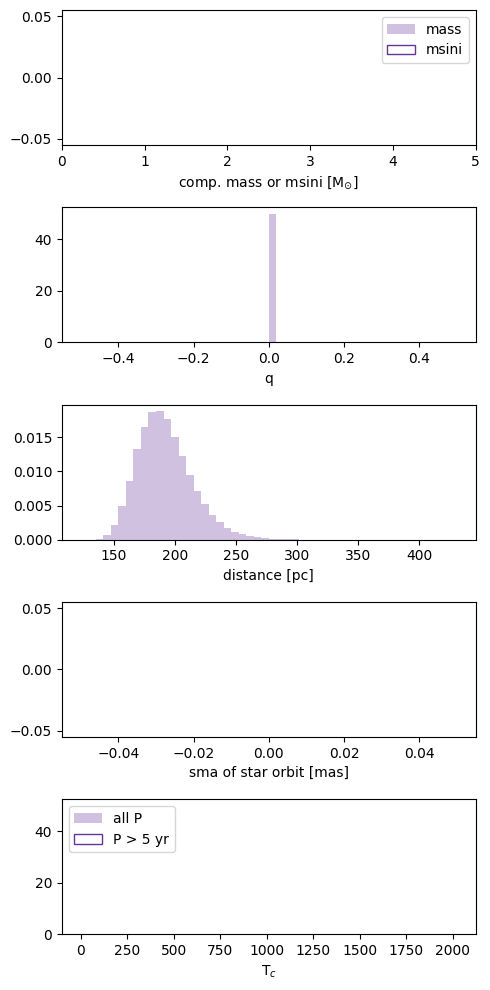

In [7]:
fig, ax = plt.subplots(5, 1, figsize=(5, 10))

m0_mask = (beetle_results.post[:, beetle_results.param_idx["m0"]] > 12) & (
    beetle_results.post[:, beetle_results.param_idx["m0"]] < 20
)
per_mask = beetle_results.post[:, beetle_results.param_idx["per1"]] > 5

mtot = (
    beetle_results.post[:, beetle_results.param_idx["m1"]]
    + beetle_results.post[:, beetle_results.param_idx["m0"]]
)
plx_as = beetle_results.post[:, beetle_results.param_idx["plx"]] * 1e-3
m1_msol = beetle_results.post[:, beetle_results.param_idx["m1"]]


m0 = beetle_results.post[:, beetle_results.param_idx["m0"]]
sma_au = (beetle_results.post[:, beetle_results.param_idx["per1"]] ** 2 * mtot) ** (
    1 / 3
)


ax[0].hist(
    m1_msol[m0_mask],
    bins=50,
    density=True,
    color="rebeccapurple",
    alpha=0.3,
    label="mass",
)
ax[0].hist(
    m1_msol[m0_mask]
    * np.sin(beetle_results.post[:, beetle_results.param_idx["inc1"]][m0_mask]),
    bins=50,
    density=True,
    color="rebeccapurple",
    histtype="step",
    label="msini",
)
ax[0].legend()
ax[0].set_xlim(0, 5)
ax[0].set_xlabel("comp. mass or msini [M$_{{\\odot}}$]")

ax[1].hist(
    beetle_results.post[:, beetle_results.param_idx["m1"]]
    / beetle_results.post[:, beetle_results.param_idx["m0"]],
    bins=50,
    density=True,
    color="rebeccapurple",
    alpha=0.3,
)
ax[1].set_xlabel("q")


# ax[2].hist(
#     sma_au[m0_mask],  # * cst.au / cst.R_sun,
#     bins=50,
#     density=True,
#     label="all P",
#     color="rebeccapurple",
#     alpha=0.3,
# )
# ax[2].hist(
#     sma_au[m0_mask & per_mask],  # * (cst.au / cst.R_sun).to(""),
#     bins=50,
#     density=True,
#     color="rebeccapurple",
#     histtype="step",
#     label="P > 5 yr",
# )
# ax[2].legend()
# ax[2].set_xlabel("sma [au]")

ax[2].hist(1 / plx_as, bins=50, density=True, color="rebeccapurple", alpha=0.3)
ax[2].set_xlabel("distance [pc]")

dist_pc = 1 / plx_as

sma_star_mas = (
    (
        (
            sma_au[m0_mask & per_mask]
            * m1_msol[m0_mask & per_mask]
            / mtot[m0_mask & per_mask]
        )
        * u.au
        / (dist_pc[m0_mask & per_mask] * u.pc)
    ).to("")
    * 206265.0
    * 1e3
)

ax[3].hist(sma_star_mas, bins=50, density=True, color="rebeccapurple", alpha=0.3)

ax[3].set_xlabel("sma of star orbit [mas]")


tP_post = tau_to_tp(
    beetle_results.post[:, beetle_results.param_idx["tau1"]],
    beetle_results.tau_ref_epoch,
    beetle_results.post[:, beetle_results.param_idx["per1"]],
)
ecc = 0
aop = np.pi
per_post_days = beetle_results.post[:, beetle_results.param_idx["per1"]] * 365.25

# conversion code stolen from radvel
f = np.pi / 2 - aop  # true anomaly during transit
ee = 2 * np.arctan(np.tan(f / 2) * np.sqrt((1 - ecc) / (1 + ecc)))  # eccentric anomaly

tc_post = tP_post + per_post_days / (2 * np.pi) * (
    ee - ecc * np.sin(ee)
)  # time of conjunction


after_date = after_date = Time(2020, format="decimalyear").mjd
num_periods = (after_date - tc_post) / per_post_days
num_periods = np.ceil(num_periods).astype(int)
tc_post += num_periods * per_post_days

ax[4].hist(
    Time(tc_post, format="mjd").decimalyear,
    bins=50,
    color="rebeccapurple",
    density=True,
    alpha=0.3,
    label="all P",
)
ax[4].hist(
    Time(tc_post[per_mask], format="mjd").decimalyear,
    bins=50,
    color="rebeccapurple",
    density=True,
    histtype="step",
    label="P > 5 yr",
)

ax[4].legend()
ax[4].set_xlabel("T$_c$")

plt.tight_layout()
plt.savefig("{}/mass_period.png".format(savedir), dpi=250)

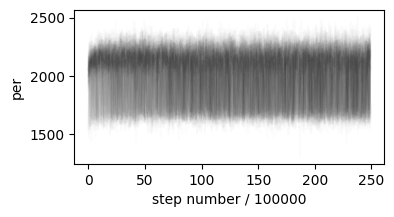

In [44]:
# make MCMC convergence plots
params = {"per1": "per"}
for param in params.keys():
    chn = beetle_results.post[:, beetle_results.system.param_idx[param]] * 365.25

    num_walkers = 1000
    thin = 100
    n_steps = len(chn) // num_walkers
    chn = chn.reshape((num_walkers, n_steps))

    walkers_to_plot = np.random.choice(num_walkers, size=100, replace=False)
    plt.figure(figsize=(4, 2))
    chop_after = 0
    for w in walkers_to_plot:
        plt.plot(chn[w, :][chop_after:], color="k", alpha=0.01)
    plt.xlabel("step number / {}".format(thin * num_walkers))
    plt.ylabel(params[param])
    plt.savefig(
        "{}/per_chains.png".format(savedir),
        dpi=250,
    )

Compare the PAN of the orbit with the star's rotation axis:

<>:39: SyntaxWarning: invalid escape sequence '\O'
<>:39: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_2528197/628417500.py:39: SyntaxWarning: invalid escape sequence '\O'
  ax[1].set_xlabel("$\Omega_{{\\mathrm{{B}}}}$ % 180 [deg]")


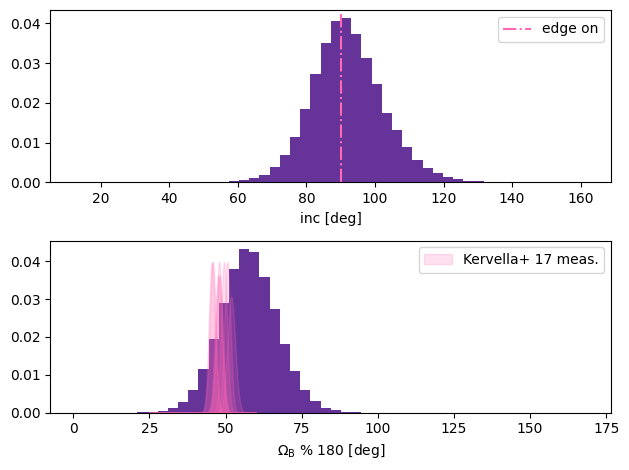

In [38]:
from scipy.stats import norm

"""
Ref for PAN of Betelgeuse:
https://www.aanda.org/articles/aa/full_html/2018/01/aa31761-17/T4.html
"""

beetle_rot_pan = [
    (48.0, 1.1),
    (47.6, 1.1),
    (49.5, 1.0),
    (47.9, 1.0),
    (51.9, 1.3),
    (50.6, 1.0),
    (45.5, 1.0),
    (45.8, 1.0),
]

fig, ax = plt.subplots(2, 1)
ax[0].hist(np.degrees(inc_post), bins=50, color="rebeccapurple", density=True)
ax[0].axvline(90, color="hotpink", ls="-.", label="edge on")
ax[0].legend()
ax[1].hist(np.degrees(pan_post) % 180, bins=50, color="rebeccapurple", density=True)

xs = np.linspace(25, 60, 200)
for i, (pan_est, pan_unc) in enumerate(beetle_rot_pan):
    gaussian_pdf = norm(pan_est, pan_unc).pdf(xs)
    ax[1].fill_between(
        xs,
        gaussian_pdf / 10,
        np.zeros_like(xs),
        color="hotpink",
        alpha=0.2,
        label="Kervella+ 17 meas.",
    )
    if i == 0:
        ax[1].legend()
ax[0].set_xlabel("inc [deg]")
ax[1].set_xlabel("$\Omega_{{\\mathrm{{B}}}}$ % 180 [deg]")
plt.tight_layout()
plt.savefig("{}/mutual_inc.png".format(savedir), dpi=250)

What are the other peaks in the period posterior? Are they harmonics? Is it the length of the Hipparcos dataset?

Maximum of the window function occurs at 1793.60 d.
315.0


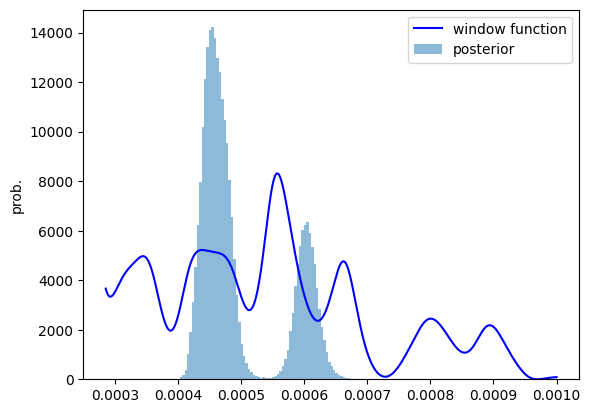

In [20]:
from astropy.timeseries import LombScargle

per_post = beetle_results.post[:, beetle_results.param_idx["per1"]] * 365.25


# total length of dataset
data_len = np.max(beetle_results.system.data_table["epoch"]) - np.min(
    beetle_results.system.data_table["epoch"]
)

# observation:
# - the peak at 3500d is sorta close to data_len / 4, and that peak is
#   nowhere near as high as the other two peaks (in the most converged version of my +planet fit)

# plot the window function
fig, ax = plt.subplots()
radio_epochs = beetle_results.system.data_table["epoch"]
hipparcos_epochs = beetle_results.system.hipparcos_IAD.epochs_mjd
all_epochs = np.sort(np.unique(np.concatenate([radio_epochs, hipparcos_epochs])))


myls = LombScargle(all_epochs, np.ones_like(all_epochs))
freq, power = myls.autopower(
    minimum_frequency=1 / 3500.0,
    maximum_frequency=1 / 1000.0,
    samples_per_peak=3000,
)

plt.plot(freq, power * 10000, color="blue", label="window function")
# plt.plot(freq - 0.00007, power * 5000, color="green")
plt.hist(1 / per_post, alpha=0.5, density=True, bins=100, label="posterior")
print(
    "Maximum of the window function occurs at {:.2f} d.".format(
        1 / freq[np.argmax(power)]
    )
)

# ax.axvline(420 * 3, label="N * 420d", ls="--", color="red")
# ax.axvline(420 * 4, ls="--", color="red")
# ax.axvline(180, ls="--", color="red")
# ax.axvline(420 * 5, ls="--", color="red")
# ax.axvline(420 * 6, ls="--", color="red")
# ax.axvline(420 * 7, ls="--", color="red")
# ax.axvline(420 * 8, ls="--", color="red")
plt.legend()
# plt.xlim(100, 3600)
# plt.xlabel("period [d]")
plt.ylabel("prob.")
plt.savefig("{}/period_window.png".format(savedir), dpi=250)

# observations:
# - at shorter periods, the window function has strong peaks at ~180 d, ~250 d,
#   and at longer periods, it's got strong peaks at 1800 and 1500 d.
# - I've tried plotting the window function and the actual posterior in
#   frequency space to see if the window function structure gets imprinted
#   on the posterior, but it doesn't line up exactly.


def print_alias(samp_per, actual_per):
    alias_per = 1 / (1 / samp_per - 1 / actual_per)
    print(alias_per)


print_alias(180, 420.0)

Re-compute the posterior given the fundamental mode/parallax constraints.

In [ ]:
# TODO